In [4]:
import os
import argparse
import configparser
import numpy as np
import numpy.linalg as la
import numpy.random as rd
import scipy.stats as ss
from pyraysum import prs
import pandas as pd
import time
import itertools as iter
import multiprocessing as mp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.ticker as ti
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
import seaborn as sb
import colorsys
from scipy.stats.contingency import margins

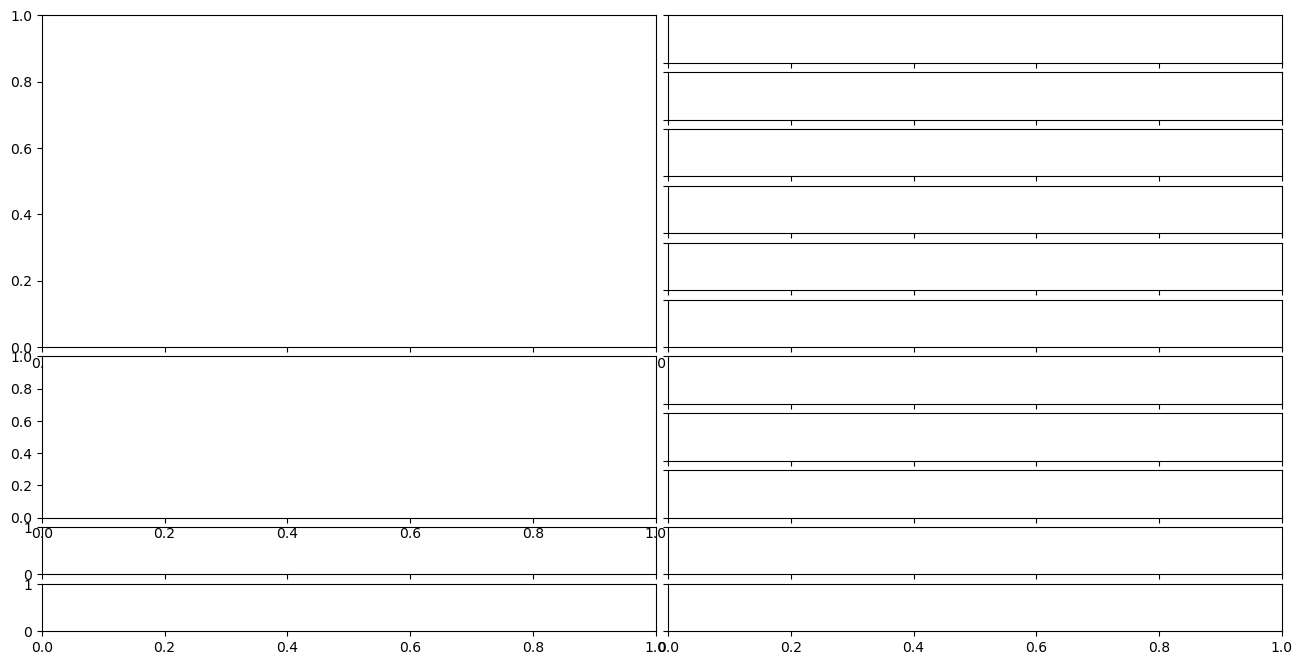

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(16, 8), sharex=True, sharey='row')

gs = ax[0, 0].get_gridspec()

for a in ax[:6, 0]:
    a.remove()
axbig = fig.add_subplot(gs[:6, 0])

for a in ax[6:9, 0]:
    a.remove()
axtau = fig.add_subplot(gs[6:9, 0])

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.02, hspace=.2)
plt.show()

In [13]:
a = [4, 5, 6]
isinstance(a, (np.ndarray, list))

True

In [39]:
path_grid = '/Users/emile/Documents/Etude/2023_2024_Cesure/Stage_Mines/inversion_synthetics/inv_grid_search_time_test/models/'
sampling = np.load(path_grid + '/grid_search_samples.npy')

In [40]:
n_params = 5
n_sample = 7

In [8]:
n_sample = 13
n_params = 3
n_proc = 10
run_time_iter = 1.1

print('Estimated run time: %i min' % (n_sample**n_params * run_time_iter/60 / n_proc))

Estimated run time: 4 min


In [49]:
z_accepted = np.load('/Users/emile/Documents/Etude/2023_2024_Cesure/Stage_Mines/inversion_synthetics/inv_metro_pol_time/models/accepted_models.npy')
n_burn = 20

z_accepted = z_accepted[n_burn:]
# z_accepted[:, -3:] -= np.nanmean(z_accepted[:, -3:], axis=0)

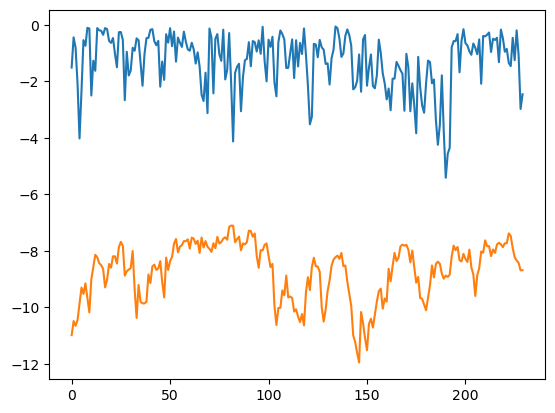

In [50]:
fig, ax = plt.subplots()

ax.plot(z_accepted[:, -2]/np.nanstd(z_accepted[:, -2]), label='time likelihood')
ax.plot(z_accepted[:, -3]/np.nanstd(z_accepted[:, -3]), label='polarity likelihood')

ax.legend()

plt.show() 

In [1]:
6500.0/3611.1

1.80000553847858

In [ ]:
def plot_dataVSmodel(data, prediction, baz, slow, title, tmax=45, **kwargs):
    idx_sort = np.argsort(baz)

    RF_arrival_d, RF_sigarrival_d, RF_pol_d, RF_amp_d = data
    RF_arrival_m, RF_pol_m, RF_amp_m = prediction
    
    n_rf = RF_arrival_d.shape[0]

    fig, ax = plt.subplots(ncols=2, nrows=11, figsize=(16, 8), sharex=True, sharey='row')

    gs = ax[0, 0].get_gridspec()
    for a in ax[:9, 0]:
        a.remove()
    axbig = fig.add_subplot(gs[:9, 0])

    tcolors = ['red', 'blue', 'green']
    tlight = [.5, .75, 1]

    for k in range(RF_arrival_d.shape[1]):

        axbig.scatter(list(range(n_rf)), RF_arrival_d[idx_sort, k], s=5, color=adjust_lightness(tcolors[k%3], amount=tlight[k//3]), zorder=5)
        axbig.scatter(list(range(n_rf)), RF_arrival_m[idx_sort, k], s=70, color=adjust_lightness(tcolors[k%3], amount=tlight[k//3]),
                      alpha=.25, zorder=4, edgecolor='None')

        ax[8-k, 1].pcolormesh(np.vstack((RF_pol_d[:, k], RF_pol_m[:, k])), cmap='bwr', vmin=-1, vmax=1)
        ax[8-k, 1].yaxis.set_tick_params(left=False)

    axbig.set_ylim(0, tmax)
    axbig.set_xlim(0, n_rf)
    ax[-1, 0].set_xlim(0, n_rf)

    ax[-2, 0].set_ylabel('Back\nazimuth (°)')
    ax[-2, 0].set_ylim(0, 360)
    ax[-2, 0].yaxis.set_major_locator(ti.MultipleLocator(180))
    ax[-2, 0].yaxis.set_minor_locator(ti.MultipleLocator(90))
    
    ax[-2, 0].scatter(list(range(n_rf)), baz[idx_sort], c='k', s=1)
    ax[-2, 1].scatter(list(range(n_rf)), baz[idx_sort], c='k', s=1)
    
    ax[-1, 0].set_ylabel('Slowness\n' + r'($s.km^{-1}$)')
    ax[-1, 0].set_ylim(.04, .08)
    ax[-1, 0].yaxis.set_major_locator(ti.MultipleLocator(.02))
    ax[-1, 0].yaxis.set_minor_locator(ti.MultipleLocator(.01))
    
    ax[-1, 0].scatter(list(range(n_rf)), slow[idx_sort], c='k', s=1)
    ax[-1, 1].scatter(list(range(n_rf)), slow[idx_sort], c='k', s=1)

    for i in range(-2, 0):
        for j in range(2):
            ax[i, j].grid(which='both', axis='y', ls='--', color='lightgrey', zorder=-10)
            ax[i, j].grid(which='major', axis='x', ls='--', color='lightgrey', zorder=-10)
    
    ax[-1, 0].set_xlabel('Event #')
    ax[-1, 1].set_xlabel('Event #')

    ax[-1, 0].xaxis.set_major_locator(ti.MultipleLocator(20))
    ax[-1, 0].xaxis.set_minor_locator(ti.MultipleLocator(10))

    ax[-1, 1].xaxis.set_major_locator(ti.MultipleLocator(20))
    ax[-1, 1].xaxis.set_minor_locator(ti.MultipleLocator(10))

    axbig.xaxis.set_major_locator(ti.MultipleLocator(20))
    axbig.xaxis.set_minor_locator(ti.MultipleLocator(10))

    axbig.xaxis.set_tick_params(labelbottom=False)
    axbig.set_ylabel('Arrival time (s)')

    legend_elements = [tuple([Line2D([0], [0], marker='o', color='none', markersize=5, markerfacecolor=adjust_lightness(tcolors[k], amount=tlight[i]), markeredgecolor='none') for i in range(3)] +
                             [Line2D([0], [0], marker='o', color='none', markersize=10, alpha=.25, markerfacecolor=adjust_lightness(tcolors[k], amount=tlight[i]), markeredgecolor='none') for i in range(3)]) for k in range(3)]
    
    axbig.legend(legend_elements, ['Moho converted waves (PS/PpS/PsS)', 'Slab top converted waves (PS/PpS/PsS)', 'ocean. Moho converted waves (PS/PpS/PsS)'],
              handler_map={tuple: HandlerTuple(ndivide=6)}, loc='upper right')

    axbig.set_title('Converted waves arrival times', fontweight='bold')

    axbig.grid(which='major', ls='--', color='lightgrey', zorder=-10)

    ax[0, 1].set_title('Converted waves polarities (transverse)', fontweight='bold')
    
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.02, hspace=.2)
    
    fig.savefig(plotdir + '/' + title + '_dataVSmodel.jpeg', dpi=300, bbox_inches='tight')
    plt.close(fig)